In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score

In [2]:
#Data Load
dataf = pd.read_csv("../Datasets/MVPdata_final.csv")

In [3]:
df = dataf[((dataf['G']>48)&(dataf['PTS']>13.5)&(dataf['MP']>30)
           &(dataf['AST']>1)&(dataf['TRB']>3)&(dataf['FG%']>0.37))]
df['Odds'] = -df['Odds']

C:\Users\xx049\AppData\Local\Temp\ipykernel_24272\1478298029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Odds'] = -df['Odds']


In [4]:
dftest = df[df['Season'] == 2023]

In [5]:
df = df[(df['Season'] >= 2007) & (df['Season'] <= 2022)]

In [6]:
df

,Unnamed: 0.1,Unnamed: 0,Season,Rank,Player,Pos,Age,G,MP,PTS,...,First,Pts Won,Pts Max,Share,MVP,Raptor Offense,Raptor Defense,Predator Offense,Predator Defense,Odds
0,0,166,2007,1,Dirk Nowitzki,PF,28,78,36.2,24.6,...,83,1138,1290,0.882,1,2.169240,1.030291,2.558710,1.427014,-800
1,1,167,2007,2,Steve Nash,PG,32,76,35.3,18.6,...,44,1013,1290,0.785,0,7.029865,-1.873767,6.812993,-2.210570,-1000
2,2,168,2007,3,Kobe Bryant,SG,28,77,40.8,31.6,...,2,521,1290,0.404,0,3.346244,-0.523628,3.457525,-0.395470,-500
3,3,169,2007,4,Tim Duncan,C,30,80,34.1,20.0,...,0,286,1290,0.222,0,2.729091,3.926063,3.008572,3.244549,-600
4,4,170,2007,5,LeBron James,SF,22,78,40.9,27.3,...,0,183,1290,0.142,0,4.870715,3.108085,4.901036,2.817517,-250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,215,380,2022,8,Stephen Curry,PG,33,64,34.5,25.5,...,0,4,1000,0.004,0,8.037072,0.823721,9.163988,1.328034,-900
216,216,381,2022,9,Chris Paul,PG,36,65,32.9,14.7,...,0,2,1000,0.002,0,5.643235,0.279849,3.355896,1.070187,-10000
217,217,382,2022,10T,DeMar DeRozan,PF,32,76,36.1,27.9,...,0,1,1000,0.001,0,0.821031,-3.813086,-1.542547,-2.658873,-99999
218,218,383,2022,10T,Kevin Durant,PF,33,55,37.2,29.9,...,0,1,1000,0.001,0,-2.574445,-6.982249,1.826958,-8.754412,-700


In [7]:
column_names = df.columns
print(column_names)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Season', 'Rank', 'Player', 'Pos', 'Age',
       'G', 'MP', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'FG%', 'eFG%', 'FT%',
       'PF', 'WS', 'WS/48', 'First', 'Pts Won', 'Pts Max', 'Share', 'MVP',
       'Raptor Offense', 'Raptor Defense', 'Predator Offense',
       'Predator Defense', 'Odds'],
      dtype='object')


In [8]:
#Feature Selections
features =  ['AST','STL', 'G', 'PTS','WS', 'eFG%', 'Raptor Offense','Raptor Defense','Predator Offense','Predator Defense', 'Odds']
X = df[features]

In [9]:
#Setting share as the target
y = df['Share']

In [10]:
#Dataset Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Bayesian Model

In [11]:
#Bayesian Training
bayesian_model = BayesianRidge()

In [12]:
bayesian_model.fit(X_train, y_train)

BayesianRidge()

In [13]:
#Run predictions
y_pred_bayesian = bayesian_model.predict(X_test)

Bayesian Ridge Model Accuracy (R-Squared)): 47.00%


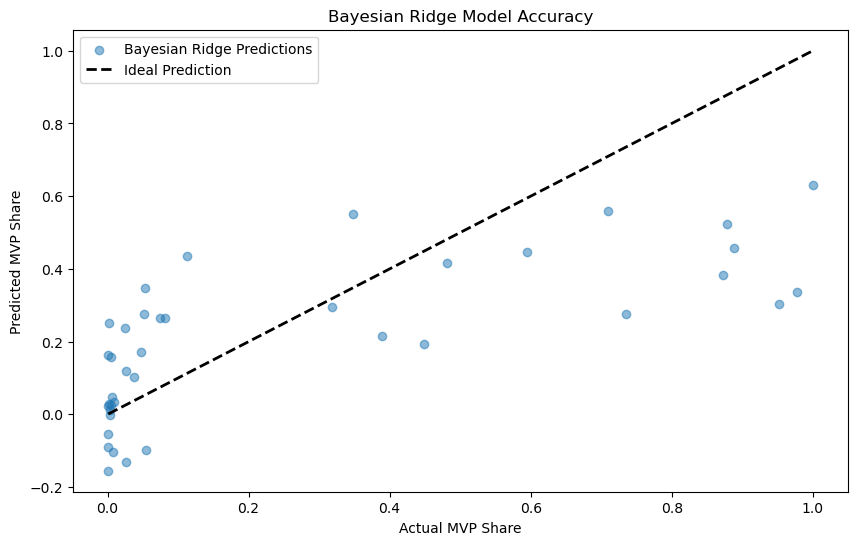

<Figure size 640x480 with 0 Axes>

In [14]:
#Evaluation
r2_bayesian = r2_score(y_test, y_pred_bayesian)
print(f"Bayesian Ridge Model Accuracy (R-Squared)): {r2_bayesian * 100:.2f}%")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_bayesian, alpha=0.5, label='Bayesian Ridge Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Prediction')
plt.xlabel('Actual MVP Share')
plt.ylabel('Predicted MVP Share')
plt.title('Bayesian Ridge Model Accuracy')
plt.legend()
plt.show()
plt.savefig('images/br_accuracy.png')

In [15]:
#Calculate correlations
correlation_matrix = df[features + ['Share']].corr()

In [16]:
#Select correlations of features with the target variable
target_correlations = correlation_matrix['Share'].drop('Share')

In [17]:
#Select correlations of features with the target variable
target_correlations = correlation_matrix['Share'].drop('Share')

In [18]:
target_correlations

AST                 0.237215
STL                 0.214441
G                   0.162833
PTS                 0.453401
WS                  0.649035
eFG%                0.292464
Raptor Offense      0.302229
Raptor Defense      0.158300
Predator Offense    0.326553
Predator Defense    0.147792
Odds                0.308158
Name: Share, dtype: float64

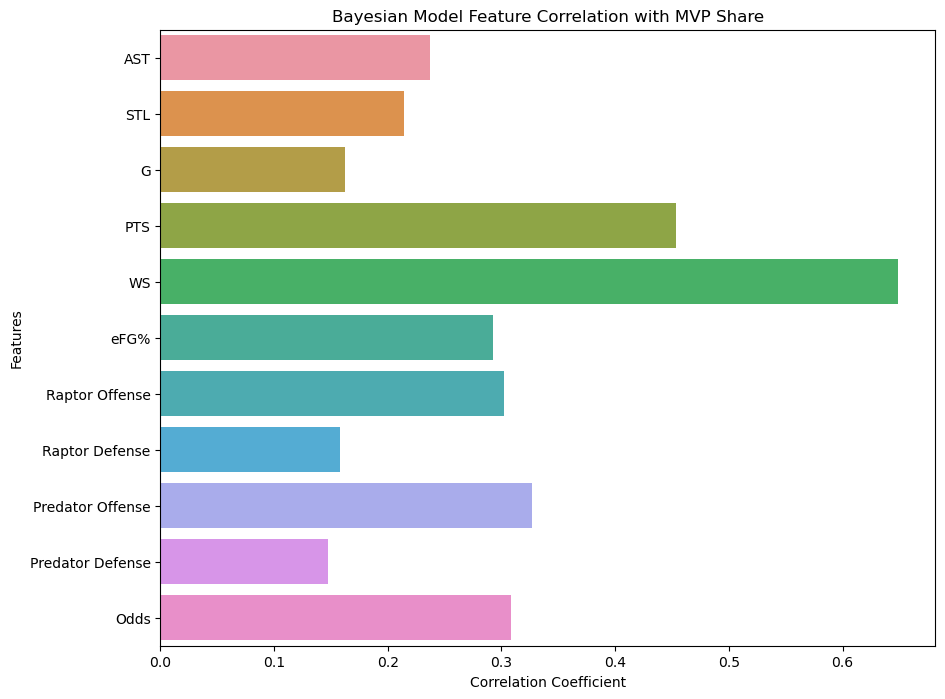

<Figure size 640x480 with 0 Axes>

In [19]:
# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=target_correlations.values, y=target_correlations.index)
plt.title('Bayesian Model Feature Correlation with MVP Share')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()
plt.savefig('images/feature_correlation.png')

In [20]:
X_test = dftest[features]
#Run predictions
y_pred_test = bayesian_model.predict(X_test)

#Making Dataframe
predicted_shares = pd.DataFrame({
    'Player': dftest['Player'],
    'Predicted Share': y_pred_test,
    'Actual Share': dftest['Share']
})
predicted_shares = predicted_shares.sort_values(by='Predicted Share', ascending=False)

In [21]:
predicted_shares

,Player,Predicted Share,Actual Share
220,Joel Embiid,0.495592,0.915
221,Nikola Jokic,0.494966,0.674
227,Luka Doncic,0.316932,0.010
224,Shai Gilgeous-Alexander,0.314897,0.046
223,Jayson Tatum,0.252595,0.280
229,Jimmy Butler,0.249971,0.003
226,Domantas Sabonis,0.235862,0.027
222,Giannis Antetokounmpo,0.167215,0.606
228,Stephen Curry,0.115568,0.005
225,Donovan Mitchell,0.091034,0.030


In [22]:
dftest

,Unnamed: 0.1,Unnamed: 0,Season,Rank,Player,Pos,Age,G,MP,PTS,...,First,Pts Won,Pts Max,Share,MVP,Raptor Offense,Raptor Defense,Predator Offense,Predator Defense,Odds
220,220,385,2023,1,Joel Embiid,C,28,66,34.6,33.1,...,73,915,1000,0.915,1,-1.985531,7.098069,-0.639339,5.590006,-600
221,221,386,2023,2,Nikola Jokic,C,27,69,33.7,24.5,...,15,674,1000,0.674,0,8.134041,2.387895,8.373640,3.123180,-900
222,222,387,2023,3,Giannis Antetokounmpo,PF,28,63,32.1,31.1,...,12,606,1000,0.606,0,-5.296677,-5.377619,-3.891641,-7.910819,-650
223,223,388,2023,4,Jayson Tatum,SF,24,74,36.9,30.1,...,0,280,1000,0.280,0,4.724842,1.134508,3.885802,0.622186,-1200
224,224,389,2023,5,Shai Gilgeous-Alexander,PG,24,68,35.5,31.4,...,0,46,1000,0.046,0,5.012312,0.161661,4.426449,0.890325,-25000
225,225,390,2023,6,Donovan Mitchell,SG,26,68,35.8,28.3,...,0,30,1000,0.030,0,5.462998,-2.381004,4.071021,-1.217394,-6600
226,226,391,2023,7,Domantas Sabonis,C,26,79,34.6,19.1,...,0,27,1000,0.027,0,-6.328715,1.634242,-5.733155,0.204437,-50000
227,227,392,2023,8,Luka Doncic,PG,23,66,36.2,32.4,...,0,10,1000,0.010,0,8.272470,-0.448862,7.922574,-0.179550,-400
228,228,393,2023,9,Stephen Curry,PG,34,56,34.7,29.4,...,0,5,1000,0.005,0,7.450293,-1.714806,6.534401,-0.943459,-1400
229,229,394,2023,10,Jimmy Butler,PF,33,64,33.4,22.9,...,0,3,1000,0.003,0,4.052923,1.246758,4.185950,2.119834,-5000
